In [1]:
import super_gradients
from super_gradients.training import models
from super_gradients import Trainer
from super_gradients.training import training_hyperparams


/home/cat/.env/tf_env/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


The console stream is logged into /home/cat/sg_logs/console.log


[2025-09-03 18:29:06] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
/home/cat/.env/tf_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-09-03 18:29:11.413433: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-03 18:29:11.429634: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756916951.448376 1161606 cuda_dnn.cc:8579] Unable to register cuDNN factory: A

In [2]:
import torch
print(torch.__version__)

f'{torch.cuda.device_count()} GPU found: {torch.cuda.get_device_name("cuda")}'

'1 GPU found: NVIDIA GeForce RTX 2050'

2.6.0+cu124


In [3]:
CHECKPOINT_DIR = '/home/cat/projects/CV-stuff/latl/classification/ckpt_folder' # Local path
EXPERIMENT_NAME = 'transfer_learning_object_detection_yolox'
trainer = Trainer(experiment_name=EXPERIMENT_NAME, ckpt_root_dir=CHECKPOINT_DIR)

# Load data

## Custom dataset

In [4]:
import cv2
import numpy as np

def letterbox_image(image, max_size=640, color=(114, 114, 114)):
    h, w = image.shape[:2]
    scale = max_size / max(h, w)
    new_w, new_h = int(w * scale), int(h * scale)
    
    # Resize while keeping aspect ratio
    resized_image = cv2.resize(image, (new_w, new_h))
    
    # Create padded image
    padded_image = np.full((max_size, max_size, 3), color, dtype=np.uint8)
    
    # Compute top-left corner for placing resized image
    top = (max_size - new_h) // 2
    left = (max_size - new_w) // 2
    
    padded_image[top:top+new_h, left:left+new_w] = resized_image
    return padded_image, scale, left, top

def coco_to_yolo_all(boxes, img_width, img_height):
    """
    Convert multiple COCO bboxes to YOLO format.

    Parameters:
        boxes: numpy array of shape (N, 4), COCO format [x_min, y_min, w, h]
        img_width: int
        img_height: int

    Returns:
        yolo_boxes: numpy array of shape (N, 4), YOLO format [x_center, y_center, w, h]
    """
    # Compute center coordinates
    x_center = boxes[:, 0] + boxes[:, 2] / 2
    y_center = boxes[:, 1] + boxes[:, 3] / 2

    # Normalize
    x_center_norm = x_center / img_width
    y_center_norm = y_center / img_height
    w_norm = boxes[:, 2] / img_width
    h_norm = boxes[:, 3] / img_height

    yolo_boxes = np.stack([x_center_norm, y_center_norm, w_norm, h_norm], axis=1)
    return yolo_boxes


def convert_image_to_yolo(image, allboxes, max_size=640):
    """
    Convert an image and its bounding boxes to a format suitable for YOLO training.

    Parameters:
        image: numpy array of shape (H, W, C)
        boxes: numpy array of shape (N, 4) with COCO format [x_min, y_min, width, height]
        max_size: int, size to which the image will be resized 

    Returns:
        image_tensor: torch.Tensor of shape (C, H, W)
        target_array: numpy array of shape (N, 5) with YOLO format [class_label, x_center_norm, y_center_norm, width_norm, height_norm]
    """

    # Letterbox resize
    padded_img, scale, pad_left, pad_top = letterbox_image(image, max_size)

    # Adjust bounding boxes after resizing + padding
    boxes = allboxes * scale
    boxes[:, 0] += pad_left   # x
    boxes[:, 1] += pad_top    # y
    new_boxes = coco_to_yolo_all(boxes, max_size, max_size)

    return padded_img, new_boxes


In [5]:
# import torch
# from torch.utils.data import Dataset
# import pandas as pd
# import os
# from PIL import Image
# import numpy as np

# class CustomCSVDataset(Dataset):
#     def __init__(self, csv_file, images_dir, max_size=640):
#         """
#         :param csv_file: path to the annotations csv file
#         :param images_dir: folder where images are stored
#         """
#         self.annotations = pd.read_csv(csv_file)
#         self.images_dir = images_dir
#         self.max_size = max_size

#         # Group annotations by image for easier retrieval
#         self.image_groups = self.annotations.groupby("image_id")

#         # Keep unique image rows
#         self.image_infos = self.annotations.drop_duplicates("image_id")

#     def __len__(self):
#         return len(self.image_infos)

#     def __getitem__(self, idx):
#         # Get one image info row
#         img_info = self.image_infos.iloc[idx]

#         img_path = os.path.join(self.images_dir, img_info["file_name"])
        
#         # Load image with OpenCV (BGR)
#         image = cv2.imread(img_path)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#         # Get annotations for this image
#         annots = self.image_groups.get_group(img_info["image_id"])
#         boxes = np.stack(annots["bbox"].apply(eval).values)  # [x-top-left,y-top-left,w,h]
#         labels = annots["category_id"].values
#         # attributes = annots["attribute_ids"].apply(lambda x: eval(x) if isinstance(x, str) else []).values
        
#         # image should be resized to max_size x max_size
#         # and padded with some color if necessary
#         # yolo takes bbox in [normalized_x_center, normalized_y_center, normalized_bbox_width, normalized_bbox_height] format
#         padded_img, padded_boxes = convert_image_to_yolo(image, boxes, self.max_size)

#         image_tensor = torch.from_numpy(padded_img).permute(2, 0, 1).float()
#         # target = {
#         #     "boxes": torch.tensor(boxes, dtype=torch.float32),
#         #     "labels": torch.tensor(labels, dtype=torch.int64),
#             # "attributes": attributes,
#             # "image_id": torch.tensor(img_info["image_id"]),
#         # }
#         target_array = np.hstack((labels.reshape(-1, 1), padded_boxes))

#         return image_tensor, target_array


In [6]:
# dataset_path = "/home/cat/projects/CV-stuff/datasets/fashionpedia/"
# img_train_root = dataset_path + "train/"
# img_val_root = dataset_path + "test/"

# ann_com_train = "instances_attributes_commercial_train_filtered.csv"
# ann_com_val = "instances_attributes_commercial_val_filtered.csv"
# info_com = "info_test2020.json"

# json_com_train = "instances_attributes_train2020_filtered_test.json"
# json_com_val = "instances_attributes_val2020_filtered_test.json"


In [7]:

# train_dataset = CustomCSVDataset(dataset_path+ann_com_train, img_train_root)
# val_dataset = CustomCSVDataset(dataset_path+ann_com_val, img_val_root)

In [8]:
# annotations = pd.read_csv(dataset_path+ann_com_val)
# one_image = annotations[annotations['image_id'] == 17039].head(10)
# one_image

In [9]:

# def draw_yolo_box(img, yolo_bbox, color=(0, 0, 255), thickness=2):
#     """
#     Draw a YOLO-format bbox on an image.

#     Parameters:
#         img: numpy array (OpenCV image)
#         yolo_bbox: list of 4 floats [x_center_norm, y_center_norm, w_norm, h_norm]
#         color: tuple, BGR color
#         thickness: int, line thickness
#     """
#     H, W = img.shape[:2]

#     cx_norm, cy_norm, w_norm, h_norm = yolo_bbox

#     # Convert normalized center coordinates to absolute pixel coordinates
#     cx = cx_norm * W
#     cy = cy_norm * H
#     w = w_norm * W
#     h = h_norm * H

#     # Compute top-left and bottom-right corners
#     x1 = int(cx - w / 2)
#     y1 = int(cy - h / 2)
#     x2 = int(cx + w / 2)
#     y2 = int(cy + h / 2)

#     # Draw rectangle
#     cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness)



In [10]:
# Test converting an image and its bounding boxes to YOLO format

# img = cv2.imread(img_val_root+one_image['file_name'][0], cv2.IMREAD_COLOR)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img_boxes = img.copy()
# bboxes = one_image['bbox'].apply(eval).values
# bboxes = np.stack(bboxes)
# for bbox in bboxes:
#     # print(bbox)
#     x, y, w, h = bbox[0], bbox[1], bbox[2], bbox[3]
#     x, y, w, h = int(x), int(y), int(w), int(h)  # ensure integers
#     # print(x, y, w, h)
#     # Draw rectangle (BGR color: red)
#     cv2.rectangle(img_boxes, (x, y), (x + w, y + h), (0, 0, 255), 2)
# img_pil = Image.fromarray(img_boxes)

# padded_img, padded_boxes = convert_image_to_yolo(img, bboxes, 640)

# for box in padded_boxes:
#     draw_yolo_box(padded_img, box, color=(0, 255, 0), thickness=2)

# letter_pil = Image.fromarray(padded_img)

# display(letter_pil)

In [11]:
# fd = pd.read_csv(dataset_path + ann_com_train)
# print(len(fd["category_id"].unique()))

# # NUM_CLASSES = len(fd["category_id"].unique())
# NUM_CLASSES = 46

In [12]:
# val_dataset[1][0]

In [13]:
# val_dataset[1][0].shape

In [14]:
# #
# val_dataset[1][1]

In [15]:
# val_dataset[1][1].shape

In [16]:
# from torch.utils.data import Dataset, DataLoader
# from super_gradients.training.utils.collate_fn.detection_collate_fn import DetectionCollateFN

# train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, collate_fn=DetectionCollateFN())
# val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2, collate_fn=DetectionCollateFN())
 

In [17]:

# next(iter(val_dataloader))[1]

In [18]:
# import os
# import pandas as pd

# # paths
# csv_file = dataset_path+ann_com_val
# images_dir = img_val_root

# # load csv
# df = pd.read_csv(csv_file)

# # track missing files
# missing_files = []

# for fname in df["file_name"]:
#     img_path = os.path.join(images_dir, fname)
#     if not os.path.exists(img_path):
#         missing_files.append(fname)

# print(f"Total images listed in CSV: {len(df)}")
# print(f"Missing images: {len(missing_files)}")

# if missing_files:
#     print("Examples of missing files:")
#     print(missing_files[:20])  # print first 20 missing


## cocoformat detection dataset and DataLoaders

In [19]:
dataset_path = "/home/cat/projects/CV-stuff/datasets/fashionpedia/"
img_train_root = dataset_path + "train/"
img_val_root = dataset_path + "test/"

ann_com_train = "instances_attributes_commercial_train_filtered.csv"
ann_com_val = "instances_attributes_commercial_val_filtered.csv"
info_com = "info_test2020.json"

json_com_train = "instances_attributes_train2020_filtered_test.json"
json_com_val = "instances_attributes_val2020_filtered_test.json"


In [20]:
import json
import torch
from torch.utils.data import Dataset
import pandas as pd
import os
from PIL import Image
import numpy as np

def load_cat_attr(dataset_path, filename):
    with open(dataset_path+filename, "r") as f:
        data = json.load(f)

    # Convert to DataFrames
    df_attributes = pd.DataFrame(data["attributes"])
    df_categories = pd.DataFrame(data["categories"])
    return df_categories, df_attributes

In [21]:
cat, attr = load_cat_attr(dataset_path, info_com)
CLASS_NAMES = cat["name"].values.tolist()
NUM_CLASSES = len(CLASS_NAMES)

In [22]:
NUM_CLASSES

46

In [23]:
from super_gradients.training.datasets.detection_datasets.coco_format_detection import COCOFormatDetectionDataset
from super_gradients.training.transforms.transforms import (
    DetectionRandomAffine,
    DetectionHSV,
    DetectionHorizontalFlip,
    DetectionPaddedRescale,
    DetectionStandardize,
    DetectionTargetsFormatTransform,
)
from super_gradients.training.utils.collate_fn import DetectionCollateFN

# json_com_train = "instances_attributes_train2020_filtered_test.json"
# json_com_val = "instances_attributes_val2020_filtered_test.json"

train_dataset_params = dict(
    data_dir=dataset_path,
    images_dir="train",
    json_annotation_file="instances_attributes_train2020_filtered.json",
    input_dim=(640, 640),
    ignore_empty_annotations=False,
    with_crowd=False,
    all_classes_list=CLASS_NAMES,
    transforms=[
        DetectionRandomAffine(degrees=30.0, scales=(0.5, 1.5), shear=0.0, target_size=(640, 640), filter_box_candidates=False, border_value=114),
        DetectionHSV(prob=1.0, hgain=15, vgain=40, sgain=40),
        DetectionHorizontalFlip(prob=0.5),
        # should be the last
        DetectionPaddedRescale(input_dim=(640, 640)),
        # DetectionStandardize(max_value=255),
        DetectionTargetsFormatTransform(input_dim=(640, 640), output_format="LABEL_CXCYWH"),
    ],
)

valid_dataset_params = dict(
    data_dir=dataset_path,
    images_dir="test",
    json_annotation_file="instances_attributes_val2020_filtered.json",
    input_dim=(640, 640),
    ignore_empty_annotations=False,
    with_crowd=False,
    all_classes_list=CLASS_NAMES,
    transforms=[
        DetectionPaddedRescale(input_dim=(640, 640), max_targets=300),
        # DetectionStandardize(max_value=255),
        DetectionTargetsFormatTransform(input_dim=(640, 640), output_format="LABEL_CXCYWH"),
    ],
)

trainset = COCOFormatDetectionDataset(**train_dataset_params)
valset = COCOFormatDetectionDataset(**valid_dataset_params)

[2025-09-03 18:29:16] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 15645/15645 [00:00<00:00, 21494.18it/s]
[2025-09-03 18:29:17] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.


Indexing dataset annotations: 100%|██████████| 330/330 [00:00<00:00, 20512.48it/s]


In [24]:
from torch.utils.data import DataLoader

NUM_WORKERS = 0
BATCH_SIZE = 8

train_dataloader_params = {
    "shuffle": True,
    "batch_size": BATCH_SIZE,
    "drop_last": True,
    "pin_memory": True,
    "collate_fn": DetectionCollateFN(),
    "num_workers": NUM_WORKERS,
    "persistent_workers": NUM_WORKERS > 0,
}

val_dataloader_params = {
    "shuffle": False,
    "batch_size": BATCH_SIZE,
    "drop_last": False,
    "pin_memory": True,
    "collate_fn": DetectionCollateFN(),
    "num_workers": NUM_WORKERS,
    "persistent_workers": NUM_WORKERS > 0,
}

train_loader = DataLoader(trainset, **train_dataloader_params)
valid_loader = DataLoader(valset, **val_dataloader_params)

In [25]:
# next(iter(train_loader))[1]

# Model training

In [26]:
# for the first use
# model = models.get("yolox_n", num_classes=NUM_CLASSES, pretrained_weights="coco")

# load from the checkpoint
LAST_RUN_NAME = "RUN_20250827_151728_644027"
BEST_WEIGHTS = "ckpt_best.pth"
checkpoint_path = os.path.join(CHECKPOINT_DIR, EXPERIMENT_NAME, LAST_RUN_NAME, BEST_WEIGHTS)
print(checkpoint_path)
model = models.get("yolox_n", num_classes=NUM_CLASSES, checkpoint_path=checkpoint_path)
print('Num classes in the model:', model.num_classes)

/home/cat/projects/CV-stuff/latl/classification/ckpt_folder/transfer_learning_object_detection_yolox/RUN_20250827_151728_644027/ckpt_best.pth


/home/cat/.env/tf_env/lib/python3.10/site-packages/super_gradients/common/deprecate.py:279: DeprecationWarning: Parameter `arch_params.channels_in` is deprecated since version `3.3.0` and will be removed in version `4.0.0`.
Please update your code to use the `arch_params.in_channels` instead of `arch_params.channels_in`.
  warnings.warn(message, DeprecationWarning)
[2025-09-03 18:29:20] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/cat/projects/CV-stuff/latl/classification/ckpt_folder/transfer_learning_object_detection_yolox/RUN_20250827_151728_644027/ckpt_best.pth EMA checkpoint.


Num classes in the model: 46


In [27]:
train_params = training_hyperparams.get('coco2017_yolox')

train_params
# from super_gradients.training.losses import PPYoloELoss
# from super_gradients.training.metrics import DetectionMetrics_050
# from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

# train_params = {
#     "warmup_initial_lr": 1e-5,
#     "initial_lr": 5e-4,
#     "lr_mode": "cosine",
#     "cosine_final_lr_ratio": 0.5,
#     "optimizer": "AdamW",
#     "zero_weight_decay_on_bias_and_bn": True,
#     "lr_warmup_epochs": 1,
#     "warmup_mode": "LinearEpochLRWarmup",
#     "optimizer_params": {"weight_decay": 0.0001},
#     "ema": False,
#     "average_best_models": False,
#     "ema_params": {"beta": 25, "decay_type": "exp"},
#     "max_epochs": 10,
#     "mixed_precision": True,
#     "loss": PPYoloELoss(use_static_assigner=False, num_classes=NUM_CLASSES, reg_max=16),
#     "valid_metrics_list": [
#         DetectionMetrics_050(
#             score_thres=0.1,
#             top_k_predictions=300,
#             num_cls=NUM_CLASSES,
#             normalize_targets=True,
#             include_classwise_ap=True,
#             class_names=CLASS_NAMES,
#             post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01, nms_top_k=1000, max_predictions=300, nms_threshold=0.7),
#         )
#     ],
#     "metric_to_watch": "mAP@0.50",
# }
     

{'resume': None,
 'run_id': None,
 'resume_path': None,
 'resume_from_remote_sg_logger': False,
 'ckpt_name': 'ckpt_latest.pth',
 'lr_mode': 'CosineLRScheduler',
 'lr_schedule_function': None,
 'lr_warmup_epochs': 5,
 'lr_warmup_steps': 0,
 'lr_cooldown_epochs': 15,
 'warmup_initial_lr': None,
 'step_lr_update_freq': None,
 'cosine_final_lr_ratio': 0.05,
 'warmup_mode': 'LinearEpochLRWarmup',
 'lr_updates': [],
 'pre_prediction_callback': None,
 'optimizer': 'SGD',
 'optimizer_params': {'momentum': 0.9, 'weight_decay': 0.0005, 'nesterov': True},
 'load_opt_params': True,
 'zero_weight_decay_on_bias_and_bn': True,
 'loss': 'YoloXDetectionLoss',
 'criterion_params': {'strides': [8, 16, 32], 'num_classes': 80},
 'ema': True,
 'ema_params': {'decay': 0.9999, 'decay_type': 'exp', 'beta': 15},
 'train_metrics_list': [],
 'valid_metrics_list': [{'DetectionMetrics': {'normalize_targets': True, 'post_prediction_callback': YoloXPostPredictionCallback(), 'num_cls': 80}}],
 'metric_to_watch': 'mAP

In [ ]:

from super_gradients.training.models.detection_models.yolo_base import YoloXPostPredictionCallback
train_params['max_epochs'] = 20
train_params['lr_warmup_epochs'] = 0
train_params['lr_cooldown_epochs'] = 0
train_params['criterion_params']['num_classes'] = NUM_CLASSES
train_params['average_best_models'] = False
train_params['initial_lr'] = 0.0005
train_params['optimizer'] = 'AdamW'
train_params['optimizer_params'] = {'weight_decay': 0.00001}
train_params['cosine_final_lr_ratio'] = 0.9
train_params['mixed_precision'] = False
train_params['valid_metrics_list'] = [{'DetectionMetrics': {'normalize_targets': True, 'post_prediction_callback': YoloXPostPredictionCallback(), 'num_cls': NUM_CLASSES}}]

In [31]:
train_params

{'resume': None,
 'run_id': None,
 'resume_path': None,
 'resume_from_remote_sg_logger': False,
 'ckpt_name': 'ckpt_latest.pth',
 'lr_mode': 'CosineLRScheduler',
 'lr_schedule_function': None,
 'lr_warmup_epochs': 0,
 'lr_warmup_steps': 0,
 'lr_cooldown_epochs': 0,
 'warmup_initial_lr': None,
 'step_lr_update_freq': None,
 'cosine_final_lr_ratio': 0.9,
 'warmup_mode': 'LinearEpochLRWarmup',
 'lr_updates': [],
 'pre_prediction_callback': None,
 'optimizer': 'AdamW',
 'optimizer_params': {'weight_decay': 1e-05},
 'load_opt_params': True,
 'zero_weight_decay_on_bias_and_bn': True,
 'loss': 'YoloXDetectionLoss',
 'criterion_params': {'strides': [8, 16, 32], 'num_classes': 46},
 'ema': True,
 'ema_params': {'decay': 0.9999, 'decay_type': 'exp', 'beta': 15},
 'train_metrics_list': [],
 'valid_metrics_list': [{'DetectionMetrics': {'normalize_targets': True,
    'post_prediction_callback': YoloXPostPredictionCallback(),
    'num_cls': 46}}],
 'metric_to_watch': 'mAP@0.50:0.95',
 'greater_metri

In [3]:

%load_ext tensorboard
# '/home/cat/projects/CV-stuff/latl/classification/ckpt_folder' # Local path
# EXPERIMENT_NAME = 'transfer_learning_object_detection_yolox'
%tensorboard --logdir /home/cat/projects/CV-stuff/latl/classification/ckpt_folder --bind_all

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 1144083), started 0:08:37 ago. (Use '!kill 1144083' to kill it.)

In [34]:
trainer.train(model=model, training_params=train_params, train_loader=train_loader, valid_loader=valid_loader)


[2025-08-27 15:17:28] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20250827_151728_644027`
[2025-08-27 15:17:28] INFO - sg_trainer.py - Checkpoints directory: /home/cat/projects/CV-stuff/latl/classification/ckpt_folder/transfer_learning_object_detection_yolox/RUN_20250827_151728_644027
[2025-08-27 15:17:28] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9999, 'decay_type': 'exp', 'beta': 15}
/home/cat/.env/tf_env/lib/python3.10/site-packages/super_gradients/training/utils/optimizer_utils.py:108: DeprecationWarning: initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
  warnings.warn(
/home/cat/.env/tf_env/lib/python3.10/site-packages/super_gradients/training/sg_trainer/sg_trainer.py:1753: FutureWarning: `to

The console stream is now moved to /home/cat/projects/CV-stuff/latl/classification/ckpt_folder/transfer_learning_object_detection_yolox/RUN_20250827_151728_644027/console_Aug27_15_17_28.txt


[2025-08-27 15:17:28] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            15645      (len(train_set))
    - Batch size per GPU:           8          (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             8          (num_gpus * batch_size)
    - Effective Batch size:         8          (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         1955       (len(train_loader))
    - Gradient updates per epoch:   1955       (len(train_loader) / batch_accumulate)
    - Model: YoloX_N  (905.53K parameters, 905.53K optimized)
    - Learning Rates and Weight Decays:
      - default: (905.53K parameters). LR: 0.0005 (905.53K parameters) WD: 0.0, (15.54K parameters), WD: 1e-05, (889.98K parameters)

[2025-08-27 15:17:28] INFO - sg_trainer.py - Started training for

SUMMARY OF EPOCH 0
├── Train
│   ├── Yoloxdetectionloss/iou = 0.3768
│   ├── Yoloxdetectionloss/obj = 1.5009
│   ├── Yoloxdetectionloss/cls = 0.6935
│   ├── Yoloxdetectionloss/l1 = 0.0
│   ├── Yoloxdetectionloss/num_fg = 7.0023
│   └── Yoloxdetectionloss/loss = 4.0786
└── Validation
    ├── Yoloxdetectionloss/iou = 0.4765
    ├── Yoloxdetectionloss/obj = 1.946
    ├── Yoloxdetectionloss/cls = 0.8304
    ├── Yoloxdetectionloss/l1 = 0.0
    ├── Yoloxdetectionloss/num_fg = 6.2387
    ├── Yoloxdetectionloss/loss = 5.1588
    ├── Precision@0.50:0.95 = 0.1751
    ├── Recall@0.50:0.95 = 0.2556
    ├── Map@0.50:0.95 = 0.1958
    ├── F1@0.50:0.95 = 0.1968
    └── Best_score_threshold = 0.32



Validating epoch 1: 100%|██████████| 42/42 [00:06<00:00,  6.20it/s]
[2025-08-27 15:44:12] INFO - base_sg_logger.py - Checkpoint saved in /home/cat/projects/CV-stuff/latl/classification/ckpt_folder/transfer_learning_object_detection_yolox/RUN_20250827_151728_644027/ckpt_best.pth
[2025-08-27 15:44:12] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.2077370285987854
Train epoch 2:   0%|          | 0/1955 [00:00<?, ?it/s]

SUMMARY OF EPOCH 1
├── Train
│   ├── Yoloxdetectionloss/iou = 0.3784
│   │   ├── Epoch N-1      = 0.3768 (↗ 0.0016)
│   │   └── Best until now = 0.3768 (↗ 0.0016)
│   ├── Yoloxdetectionloss/obj = 1.5203
│   │   ├── Epoch N-1      = 1.5009 (↗ 0.0193)
│   │   └── Best until now = 1.5009 (↗ 0.0193)
│   ├── Yoloxdetectionloss/cls = 0.6967
│   │   ├── Epoch N-1      = 0.6935 (↗ 0.0033)
│   │   └── Best until now = 0.6935 (↗ 0.0033)
│   ├── Yoloxdetectionloss/l1 = 0.0
│   │   ├── Epoch N-1      = 0.0    (= 0.0)
│   │   └── Best until now = 0.0    (= 0.0)
│   ├── Yoloxdetectionloss/num_fg = 6.9956
│   │   ├── Epoch N-1      = 7.0023 (↘ -0.0067)
│   │   └── Best until now = 7.0023 (↘ -0.0067)
│   └── Yoloxdetectionloss/loss = 4.1092
│       ├── Epoch N-1      = 4.0786 (↗ 0.0306)
│       └── Best until now = 4.0786 (↗ 0.0306)
└── Validation
    ├── Yoloxdetectionloss/iou = 0.4575
    │   ├── Epoch N-1      = 0.4765 (↘ -0.019)
    │   └── Best until now = 0.4765 (↘ -0.019)
    ├── Yoloxdetection

Validating epoch 2: 100%|██████████| 42/42 [00:07<00:00,  5.61it/s]


SUMMARY OF EPOCH 2
├── Train
│   ├── Yoloxdetectionloss/iou = 0.3776
│   │   ├── Epoch N-1      = 0.3784 (↘ -0.0008)
│   │   └── Best until now = 0.3768 (↗ 0.0008)
│   ├── Yoloxdetectionloss/obj = 1.5159
│   │   ├── Epoch N-1      = 1.5203 (↘ -0.0043)
│   │   └── Best until now = 1.5009 (↗ 0.015)
│   ├── Yoloxdetectionloss/cls = 0.6922
│   │   ├── Epoch N-1      = 0.6967 (↘ -0.0045)
│   │   └── Best until now = 0.6935 (↘ -0.0012)
│   ├── Yoloxdetectionloss/l1 = 0.0
│   │   ├── Epoch N-1      = 0.0    (= 0.0)
│   │   └── Best until now = 0.0    (= 0.0)
│   ├── Yoloxdetectionloss/num_fg = 7.0101
│   │   ├── Epoch N-1      = 6.9956 (↗ 0.0145)
│   │   └── Best until now = 6.9956 (↗ 0.0145)
│   └── Yoloxdetectionloss/loss = 4.0963
│       ├── Epoch N-1      = 4.1092 (↘ -0.0129)
│       └── Best until now = 4.0786 (↗ 0.0176)
└── Validation
    ├── Yoloxdetectionloss/iou = 0.4549
    │   ├── Epoch N-1      = 0.4575 (↘ -0.0026)
    │   └── Best until now = 0.4575 (↘ -0.0026)
    ├── Yoloxdetec

Validating epoch 3: 100%|██████████| 42/42 [00:07<00:00,  5.64it/s]
[2025-08-27 16:11:22] INFO - base_sg_logger.py - Checkpoint saved in /home/cat/projects/CV-stuff/latl/classification/ckpt_folder/transfer_learning_object_detection_yolox/RUN_20250827_151728_644027/ckpt_best.pth
[2025-08-27 16:11:22] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.21263109147548676
Train epoch 4:   0%|          | 0/1955 [00:00<?, ?it/s]

SUMMARY OF EPOCH 3
├── Train
│   ├── Yoloxdetectionloss/iou = 0.3762
│   │   ├── Epoch N-1      = 0.3776 (↘ -0.0014)
│   │   └── Best until now = 0.3768 (↘ -0.0006)
│   ├── Yoloxdetectionloss/obj = 1.5101
│   │   ├── Epoch N-1      = 1.5159 (↘ -0.0058)
│   │   └── Best until now = 1.5009 (↗ 0.0091)
│   ├── Yoloxdetectionloss/cls = 0.6923
│   │   ├── Epoch N-1      = 0.6922 (↗ 1e-04)
│   │   └── Best until now = 0.6922 (↗ 1e-04)
│   ├── Yoloxdetectionloss/l1 = 0.0
│   │   ├── Epoch N-1      = 0.0    (= 0.0)
│   │   └── Best until now = 0.0    (= 0.0)
│   ├── Yoloxdetectionloss/num_fg = 7.0174
│   │   ├── Epoch N-1      = 7.0101 (↗ 0.0074)
│   │   └── Best until now = 6.9956 (↗ 0.0218)
│   └── Yoloxdetectionloss/loss = 4.0834
│       ├── Epoch N-1      = 4.0963 (↘ -0.0129)
│       └── Best until now = 4.0786 (↗ 0.0048)
└── Validation
    ├── Yoloxdetectionloss/iou = 0.4519
    │   ├── Epoch N-1      = 0.4549 (↘ -0.003)
    │   └── Best until now = 0.4549 (↘ -0.003)
    ├── Yoloxdetection

Validating epoch 4: 100%|██████████| 42/42 [00:06<00:00,  6.04it/s]


SUMMARY OF EPOCH 4
├── Train
│   ├── Yoloxdetectionloss/iou = 0.377
│   │   ├── Epoch N-1      = 0.3762 (↗ 0.0008)
│   │   └── Best until now = 0.3762 (↗ 0.0008)
│   ├── Yoloxdetectionloss/obj = 1.5181
│   │   ├── Epoch N-1      = 1.5101 (↗ 0.0081)
│   │   └── Best until now = 1.5009 (↗ 0.0172)
│   ├── Yoloxdetectionloss/cls = 0.6903
│   │   ├── Epoch N-1      = 0.6923 (↘ -0.002)
│   │   └── Best until now = 0.6922 (↘ -0.0019)
│   ├── Yoloxdetectionloss/l1 = 0.0
│   │   ├── Epoch N-1      = 0.0    (= 0.0)
│   │   └── Best until now = 0.0    (= 0.0)
│   ├── Yoloxdetectionloss/num_fg = 7.013
│   │   ├── Epoch N-1      = 7.0174 (↘ -0.0044)
│   │   └── Best until now = 6.9956 (↗ 0.0174)
│   └── Yoloxdetectionloss/loss = 4.0935
│       ├── Epoch N-1      = 4.0834 (↗ 0.0101)
│       └── Best until now = 4.0786 (↗ 0.0149)
└── Validation
    ├── Yoloxdetectionloss/iou = 0.4696
    │   ├── Epoch N-1      = 0.4519 (↗ 0.0177)
    │   └── Best until now = 0.4519 (↗ 0.0177)
    ├── Yoloxdetectionlo

Validating epoch 5: 100%|██████████| 42/42 [00:07<00:00,  5.53it/s]
[2025-08-27 16:38:24] INFO - base_sg_logger.py - Checkpoint saved in /home/cat/projects/CV-stuff/latl/classification/ckpt_folder/transfer_learning_object_detection_yolox/RUN_20250827_151728_644027/ckpt_best.pth
[2025-08-27 16:38:24] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.21432162821292877
Train epoch 6:   0%|          | 0/1955 [00:00<?, ?it/s]

SUMMARY OF EPOCH 5
├── Train
│   ├── Yoloxdetectionloss/iou = 0.3771
│   │   ├── Epoch N-1      = 0.377  (↗ 1e-04)
│   │   └── Best until now = 0.3762 (↗ 0.0009)
│   ├── Yoloxdetectionloss/obj = 1.5233
│   │   ├── Epoch N-1      = 1.5181 (↗ 0.0052)
│   │   └── Best until now = 1.5009 (↗ 0.0224)
│   ├── Yoloxdetectionloss/cls = 0.695
│   │   ├── Epoch N-1      = 0.6903 (↗ 0.0047)
│   │   └── Best until now = 0.6903 (↗ 0.0047)
│   ├── Yoloxdetectionloss/l1 = 0.0
│   │   ├── Epoch N-1      = 0.0    (= 0.0)
│   │   └── Best until now = 0.0    (= 0.0)
│   ├── Yoloxdetectionloss/num_fg = 7.0088
│   │   ├── Epoch N-1      = 7.013  (↘ -0.0042)
│   │   └── Best until now = 6.9956 (↗ 0.0132)
│   └── Yoloxdetectionloss/loss = 4.1039
│       ├── Epoch N-1      = 4.0935 (↗ 0.0104)
│       └── Best until now = 4.0786 (↗ 0.0252)
└── Validation
    ├── Yoloxdetectionloss/iou = 0.4556
    │   ├── Epoch N-1      = 0.4696 (↘ -0.014)
    │   └── Best until now = 0.4519 (↗ 0.0038)
    ├── Yoloxdetectionlos

Validating epoch 6: 100%|██████████| 42/42 [00:06<00:00,  6.14it/s]
[2025-08-27 16:51:47] INFO - base_sg_logger.py - Checkpoint saved in /home/cat/projects/CV-stuff/latl/classification/ckpt_folder/transfer_learning_object_detection_yolox/RUN_20250827_151728_644027/ckpt_best.pth
[2025-08-27 16:51:47] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.22656147181987762
Train epoch 7:   0%|          | 0/1955 [00:00<?, ?it/s]

SUMMARY OF EPOCH 6
├── Train
│   ├── Yoloxdetectionloss/iou = 0.3773
│   │   ├── Epoch N-1      = 0.3771 (↗ 0.0002)
│   │   └── Best until now = 0.3762 (↗ 0.0011)
│   ├── Yoloxdetectionloss/obj = 1.5352
│   │   ├── Epoch N-1      = 1.5233 (↗ 0.0118)
│   │   └── Best until now = 1.5009 (↗ 0.0342)
│   ├── Yoloxdetectionloss/cls = 0.6962
│   │   ├── Epoch N-1      = 0.695  (↗ 0.0012)
│   │   └── Best until now = 0.6903 (↗ 0.0059)
│   ├── Yoloxdetectionloss/l1 = 0.0
│   │   ├── Epoch N-1      = 0.0    (= 0.0)
│   │   └── Best until now = 0.0    (= 0.0)
│   ├── Yoloxdetectionloss/num_fg = 7.0176
│   │   ├── Epoch N-1      = 7.0088 (↗ 0.0088)
│   │   └── Best until now = 6.9956 (↗ 0.022)
│   └── Yoloxdetectionloss/loss = 4.1181
│       ├── Epoch N-1      = 4.1039 (↗ 0.0142)
│       └── Best until now = 4.0786 (↗ 0.0395)
└── Validation
    ├── Yoloxdetectionloss/iou = 0.4507
    │   ├── Epoch N-1      = 0.4556 (↘ -0.005)
    │   └── Best until now = 0.4519 (↘ -0.0012)
    ├── Yoloxdetectionlo

Validating epoch 7: 100%|██████████| 42/42 [00:07<00:00,  5.36it/s]
[2025-08-27 17:05:24] INFO - base_sg_logger.py - Checkpoint saved in /home/cat/projects/CV-stuff/latl/classification/ckpt_folder/transfer_learning_object_detection_yolox/RUN_20250827_151728_644027/ckpt_best.pth
[2025-08-27 17:05:24] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.22900390625
Train epoch 8:   0%|          | 0/1955 [00:00<?, ?it/s]

SUMMARY OF EPOCH 7
├── Train
│   ├── Yoloxdetectionloss/iou = 0.3767
│   │   ├── Epoch N-1      = 0.3773 (↘ -0.0006)
│   │   └── Best until now = 0.3762 (↗ 0.0005)
│   ├── Yoloxdetectionloss/obj = 1.5307
│   │   ├── Epoch N-1      = 1.5352 (↘ -0.0045)
│   │   └── Best until now = 1.5009 (↗ 0.0297)
│   ├── Yoloxdetectionloss/cls = 0.6963
│   │   ├── Epoch N-1      = 0.6962 (↗ 1e-04)
│   │   └── Best until now = 0.6903 (↗ 0.006)
│   ├── Yoloxdetectionloss/l1 = 0.0
│   │   ├── Epoch N-1      = 0.0    (= 0.0)
│   │   └── Best until now = 0.0    (= 0.0)
│   ├── Yoloxdetectionloss/num_fg = 7.0196
│   │   ├── Epoch N-1      = 7.0176 (↗ 0.002)
│   │   └── Best until now = 6.9956 (↗ 0.024)
│   └── Yoloxdetectionloss/loss = 4.1107
│       ├── Epoch N-1      = 4.1181 (↘ -0.0074)
│       └── Best until now = 4.0786 (↗ 0.032)
└── Validation
    ├── Yoloxdetectionloss/iou = 0.4483
    │   ├── Epoch N-1      = 0.4507 (↘ -0.0024)
    │   └── Best until now = 0.4507 (↘ -0.0024)
    ├── Yoloxdetectionlo

Validating epoch 8: 100%|██████████| 42/42 [00:06<00:00,  6.38it/s]
[2025-08-27 17:18:59] INFO - base_sg_logger.py - Checkpoint saved in /home/cat/projects/CV-stuff/latl/classification/ckpt_folder/transfer_learning_object_detection_yolox/RUN_20250827_151728_644027/ckpt_best.pth
[2025-08-27 17:18:59] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.23256029188632965
Train epoch 9:   0%|          | 0/1955 [00:00<?, ?it/s]

SUMMARY OF EPOCH 8
├── Train
│   ├── Yoloxdetectionloss/iou = 0.3761
│   │   ├── Epoch N-1      = 0.3767 (↘ -0.0006)
│   │   └── Best until now = 0.3762 (↘ -1e-04)
│   ├── Yoloxdetectionloss/obj = 1.5277
│   │   ├── Epoch N-1      = 1.5307 (↘ -0.003)
│   │   └── Best until now = 1.5009 (↗ 0.0267)
│   ├── Yoloxdetectionloss/cls = 0.6936
│   │   ├── Epoch N-1      = 0.6963 (↘ -0.0027)
│   │   └── Best until now = 0.6903 (↗ 0.0033)
│   ├── Yoloxdetectionloss/l1 = 0.0
│   │   ├── Epoch N-1      = 0.0    (= 0.0)
│   │   └── Best until now = 0.0    (= 0.0)
│   ├── Yoloxdetectionloss/num_fg = 7.0218
│   │   ├── Epoch N-1      = 7.0196 (↗ 0.0022)
│   │   └── Best until now = 6.9956 (↗ 0.0262)
│   └── Yoloxdetectionloss/loss = 4.1019
│       ├── Epoch N-1      = 4.1107 (↘ -0.0088)
│       └── Best until now = 4.0786 (↗ 0.0232)
└── Validation
    ├── Yoloxdetectionloss/iou = 0.4447
    │   ├── Epoch N-1      = 0.4483 (↘ -0.0036)
    │   └── Best until now = 0.4483 (↘ -0.0036)
    ├── Yoloxdetect

Validating epoch 9: 100%|██████████| 42/42 [00:06<00:00,  6.24it/s]
[2025-08-27 17:32:33] INFO - base_sg_logger.py - Checkpoint saved in /home/cat/projects/CV-stuff/latl/classification/ckpt_folder/transfer_learning_object_detection_yolox/RUN_20250827_151728_644027/ckpt_best.pth
[2025-08-27 17:32:33] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.2394423633813858
Train epoch 10:   0%|          | 0/1955 [00:00<?, ?it/s]

SUMMARY OF EPOCH 9
├── Train
│   ├── Yoloxdetectionloss/iou = 0.3754
│   │   ├── Epoch N-1      = 0.3761 (↘ -0.0007)
│   │   └── Best until now = 0.3761 (↘ -0.0007)
│   ├── Yoloxdetectionloss/obj = 1.536
│   │   ├── Epoch N-1      = 1.5277 (↗ 0.0083)
│   │   └── Best until now = 1.5009 (↗ 0.035)
│   ├── Yoloxdetectionloss/cls = 0.6943
│   │   ├── Epoch N-1      = 0.6936 (↗ 0.0008)
│   │   └── Best until now = 0.6903 (↗ 0.004)
│   ├── Yoloxdetectionloss/l1 = 0.0
│   │   ├── Epoch N-1      = 0.0    (= 0.0)
│   │   └── Best until now = 0.0    (= 0.0)
│   ├── Yoloxdetectionloss/num_fg = 7.0272
│   │   ├── Epoch N-1      = 7.0218 (↗ 0.0054)
│   │   └── Best until now = 6.9956 (↗ 0.0316)
│   └── Yoloxdetectionloss/loss = 4.1075
│       ├── Epoch N-1      = 4.1019 (↗ 0.0056)
│       └── Best until now = 4.0786 (↗ 0.0288)
└── Validation
    ├── Yoloxdetectionloss/iou = 0.439
    │   ├── Epoch N-1      = 0.4447 (↘ -0.0058)
    │   └── Best until now = 0.4447 (↘ -0.0058)
    ├── Yoloxdetectionlo

Validating epoch 10: 100%|██████████| 42/42 [00:06<00:00,  6.17it/s]
[2025-08-27 17:46:06] INFO - base_sg_logger.py - Checkpoint saved in /home/cat/projects/CV-stuff/latl/classification/ckpt_folder/transfer_learning_object_detection_yolox/RUN_20250827_151728_644027/ckpt_best.pth
[2025-08-27 17:46:06] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.24139533936977386
Train epoch 11:   0%|          | 0/1955 [00:00<?, ?it/s]

SUMMARY OF EPOCH 10
├── Train
│   ├── Yoloxdetectionloss/iou = 0.375
│   │   ├── Epoch N-1      = 0.3754 (↘ -0.0004)
│   │   └── Best until now = 0.3754 (↘ -0.0004)
│   ├── Yoloxdetectionloss/obj = 1.5404
│   │   ├── Epoch N-1      = 1.536  (↗ 0.0045)
│   │   └── Best until now = 1.5009 (↗ 0.0395)
│   ├── Yoloxdetectionloss/cls = 0.6929
│   │   ├── Epoch N-1      = 0.6943 (↘ -0.0014)
│   │   └── Best until now = 0.6903 (↗ 0.0026)
│   ├── Yoloxdetectionloss/l1 = 0.0
│   │   ├── Epoch N-1      = 0.0    (= 0.0)
│   │   └── Best until now = 0.0    (= 0.0)
│   ├── Yoloxdetectionloss/num_fg = 7.0323
│   │   ├── Epoch N-1      = 7.0272 (↗ 0.0052)
│   │   └── Best until now = 6.9956 (↗ 0.0367)
│   └── Yoloxdetectionloss/loss = 4.1084
│       ├── Epoch N-1      = 4.1075 (↗ 0.001)
│       └── Best until now = 4.0786 (↗ 0.0298)
└── Validation
    ├── Yoloxdetectionloss/iou = 0.4395
    │   ├── Epoch N-1      = 0.439  (↗ 0.0005)
    │   └── Best until now = 0.439  (↗ 0.0005)
    ├── Yoloxdetection

Validating epoch 11: 100%|██████████| 42/42 [00:06<00:00,  6.33it/s]
[2025-08-27 17:59:44] INFO - base_sg_logger.py - Checkpoint saved in /home/cat/projects/CV-stuff/latl/classification/ckpt_folder/transfer_learning_object_detection_yolox/RUN_20250827_151728_644027/ckpt_best.pth
[2025-08-27 17:59:44] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.24382707476615906
Train epoch 12:   0%|          | 0/1955 [00:00<?, ?it/s]

SUMMARY OF EPOCH 11
├── Train
│   ├── Yoloxdetectionloss/iou = 0.3727
│   │   ├── Epoch N-1      = 0.375  (↘ -0.0023)
│   │   └── Best until now = 0.375  (↘ -0.0023)
│   ├── Yoloxdetectionloss/obj = 1.5227
│   │   ├── Epoch N-1      = 1.5404 (↘ -0.0178)
│   │   └── Best until now = 1.5009 (↗ 0.0217)
│   ├── Yoloxdetectionloss/cls = 0.6887
│   │   ├── Epoch N-1      = 0.6929 (↘ -0.0043)
│   │   └── Best until now = 0.6903 (↘ -0.0016)
│   ├── Yoloxdetectionloss/l1 = 0.0
│   │   ├── Epoch N-1      = 0.0    (= 0.0)
│   │   └── Best until now = 0.0    (= 0.0)
│   ├── Yoloxdetectionloss/num_fg = 7.0451
│   │   ├── Epoch N-1      = 7.0323 (↗ 0.0128)
│   │   └── Best until now = 6.9956 (↗ 0.0495)
│   └── Yoloxdetectionloss/loss = 4.075
│       ├── Epoch N-1      = 4.1084 (↘ -0.0335)
│       └── Best until now = 4.0786 (↘ -0.0037)
└── Validation
    ├── Yoloxdetectionloss/iou = 0.438
    │   ├── Epoch N-1      = 0.4395 (↘ -0.0014)
    │   └── Best until now = 0.439  (↘ -0.001)
    ├── Yoloxdete

Validating epoch 12: 100%|██████████| 42/42 [00:06<00:00,  6.27it/s]
[2025-08-27 18:13:11] INFO - base_sg_logger.py - Checkpoint saved in /home/cat/projects/CV-stuff/latl/classification/ckpt_folder/transfer_learning_object_detection_yolox/RUN_20250827_151728_644027/ckpt_best.pth
[2025-08-27 18:13:11] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.24616394937038422
Train epoch 13:   0%|          | 0/1955 [00:00<?, ?it/s]

SUMMARY OF EPOCH 12
├── Train
│   ├── Yoloxdetectionloss/iou = 0.3718
│   │   ├── Epoch N-1      = 0.3727 (↘ -0.0009)
│   │   └── Best until now = 0.3727 (↘ -0.0009)
│   ├── Yoloxdetectionloss/obj = 1.5142
│   │   ├── Epoch N-1      = 1.5227 (↘ -0.0085)
│   │   └── Best until now = 1.5009 (↗ 0.0132)
│   ├── Yoloxdetectionloss/cls = 0.6882
│   │   ├── Epoch N-1      = 0.6887 (↘ -0.0005)
│   │   └── Best until now = 0.6887 (↘ -0.0005)
│   ├── Yoloxdetectionloss/l1 = 0.0
│   │   ├── Epoch N-1      = 0.0    (= 0.0)
│   │   └── Best until now = 0.0    (= 0.0)
│   ├── Yoloxdetectionloss/num_fg = 7.0451
│   │   ├── Epoch N-1      = 7.0451 (↘ -0.0)
│   │   └── Best until now = 6.9956 (↗ 0.0495)
│   └── Yoloxdetectionloss/loss = 4.0615
│       ├── Epoch N-1      = 4.075  (↘ -0.0134)
│       └── Best until now = 4.075  (↘ -0.0134)
└── Validation
    ├── Yoloxdetectionloss/iou = 0.4364
    │   ├── Epoch N-1      = 0.438  (↘ -0.0016)
    │   └── Best until now = 0.438  (↘ -0.0016)
    ├── Yoloxdet

Validating epoch 13: 100%|██████████| 42/42 [00:07<00:00,  5.89it/s]
[2025-08-27 18:26:52] INFO - base_sg_logger.py - Checkpoint saved in /home/cat/projects/CV-stuff/latl/classification/ckpt_folder/transfer_learning_object_detection_yolox/RUN_20250827_151728_644027/ckpt_best.pth
[2025-08-27 18:26:52] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.24702222645282745
Train epoch 14:   0%|          | 0/1955 [00:00<?, ?it/s]

SUMMARY OF EPOCH 13
├── Train
│   ├── Yoloxdetectionloss/iou = 0.3715
│   │   ├── Epoch N-1      = 0.3718 (↘ -0.0003)
│   │   └── Best until now = 0.3718 (↘ -0.0003)
│   ├── Yoloxdetectionloss/obj = 1.5021
│   │   ├── Epoch N-1      = 1.5142 (↘ -0.0121)
│   │   └── Best until now = 1.5009 (↗ 0.0011)
│   ├── Yoloxdetectionloss/cls = 0.6838
│   │   ├── Epoch N-1      = 0.6882 (↘ -0.0044)
│   │   └── Best until now = 0.6882 (↘ -0.0044)
│   ├── Yoloxdetectionloss/l1 = 0.0
│   │   ├── Epoch N-1      = 0.0    (= 0.0)
│   │   └── Best until now = 0.0    (= 0.0)
│   ├── Yoloxdetectionloss/num_fg = 7.0538
│   │   ├── Epoch N-1      = 7.0451 (↗ 0.0087)
│   │   └── Best until now = 6.9956 (↗ 0.0582)
│   └── Yoloxdetectionloss/loss = 4.0433
│       ├── Epoch N-1      = 4.0615 (↘ -0.0182)
│       └── Best until now = 4.0615 (↘ -0.0182)
└── Validation
    ├── Yoloxdetectionloss/iou = 0.4362
    │   ├── Epoch N-1      = 0.4364 (↘ -0.0003)
    │   └── Best until now = 0.4364 (↘ -0.0003)
    ├── Yoloxd

Validating epoch 14: 100%|██████████| 42/42 [00:07<00:00,  5.99it/s]
[2025-08-27 18:40:26] INFO - base_sg_logger.py - Checkpoint saved in /home/cat/projects/CV-stuff/latl/classification/ckpt_folder/transfer_learning_object_detection_yolox/RUN_20250827_151728_644027/ckpt_best.pth
[2025-08-27 18:40:26] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.24767377972602844
Train epoch 15:   0%|          | 0/1955 [00:00<?, ?it/s]

SUMMARY OF EPOCH 14
├── Train
│   ├── Yoloxdetectionloss/iou = 0.3701
│   │   ├── Epoch N-1      = 0.3715 (↘ -0.0014)
│   │   └── Best until now = 0.3715 (↘ -0.0014)
│   ├── Yoloxdetectionloss/obj = 1.5054
│   │   ├── Epoch N-1      = 1.5021 (↗ 0.0034)
│   │   └── Best until now = 1.5009 (↗ 0.0045)
│   ├── Yoloxdetectionloss/cls = 0.6841
│   │   ├── Epoch N-1      = 0.6838 (↗ 0.0003)
│   │   └── Best until now = 0.6838 (↗ 0.0003)
│   ├── Yoloxdetectionloss/l1 = 0.0
│   │   ├── Epoch N-1      = 0.0    (= 0.0)
│   │   └── Best until now = 0.0    (= 0.0)
│   ├── Yoloxdetectionloss/num_fg = 7.0646
│   │   ├── Epoch N-1      = 7.0538 (↗ 0.0108)
│   │   └── Best until now = 6.9956 (↗ 0.069)
│   └── Yoloxdetectionloss/loss = 4.0401
│       ├── Epoch N-1      = 4.0433 (↘ -0.0032)
│       └── Best until now = 4.0433 (↘ -0.0032)
└── Validation
    ├── Yoloxdetectionloss/iou = 0.4355
    │   ├── Epoch N-1      = 0.4362 (↘ -0.0007)
    │   └── Best until now = 0.4362 (↘ -0.0007)
    ├── Yoloxdetec

Validating epoch 15: 100%|██████████| 42/42 [00:07<00:00,  5.98it/s]
[2025-08-27 18:54:03] INFO - base_sg_logger.py - Checkpoint saved in /home/cat/projects/CV-stuff/latl/classification/ckpt_folder/transfer_learning_object_detection_yolox/RUN_20250827_151728_644027/ckpt_best.pth
[2025-08-27 18:54:03] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.2490539252758026
Train epoch 16:   0%|          | 0/1955 [00:00<?, ?it/s]

SUMMARY OF EPOCH 15
├── Train
│   ├── Yoloxdetectionloss/iou = 0.37
│   │   ├── Epoch N-1      = 0.3701 (↘ -1e-04)
│   │   └── Best until now = 0.3701 (↘ -1e-04)
│   ├── Yoloxdetectionloss/obj = 1.4919
│   │   ├── Epoch N-1      = 1.5054 (↘ -0.0135)
│   │   └── Best until now = 1.5009 (↘ -0.009)
│   ├── Yoloxdetectionloss/cls = 0.6772
│   │   ├── Epoch N-1      = 0.6841 (↘ -0.0069)
│   │   └── Best until now = 0.6838 (↘ -0.0066)
│   ├── Yoloxdetectionloss/l1 = 0.0
│   │   ├── Epoch N-1      = 0.0    (= 0.0)
│   │   └── Best until now = 0.0    (= 0.0)
│   ├── Yoloxdetectionloss/num_fg = 7.0561
│   │   ├── Epoch N-1      = 7.0646 (↘ -0.0085)
│   │   └── Best until now = 6.9956 (↗ 0.0605)
│   └── Yoloxdetectionloss/loss = 4.0193
│       ├── Epoch N-1      = 4.0401 (↘ -0.0209)
│       └── Best until now = 4.0401 (↘ -0.0209)
└── Validation
    ├── Yoloxdetectionloss/iou = 0.4353
    │   ├── Epoch N-1      = 0.4355 (↘ -0.0002)
    │   └── Best until now = 0.4355 (↘ -0.0002)
    ├── Yoloxdete

Validating epoch 16: 100%|██████████| 42/42 [00:06<00:00,  6.20it/s]


SUMMARY OF EPOCH 16
├── Train
│   ├── Yoloxdetectionloss/iou = 0.3685
│   │   ├── Epoch N-1      = 0.37   (↘ -0.0016)
│   │   └── Best until now = 0.37   (↘ -0.0016)
│   ├── Yoloxdetectionloss/obj = 1.4842
│   │   ├── Epoch N-1      = 1.4919 (↘ -0.0077)
│   │   └── Best until now = 1.4919 (↘ -0.0077)
│   ├── Yoloxdetectionloss/cls = 0.6757
│   │   ├── Epoch N-1      = 0.6772 (↘ -0.0015)
│   │   └── Best until now = 0.6772 (↘ -0.0015)
│   ├── Yoloxdetectionloss/l1 = 0.0
│   │   ├── Epoch N-1      = 0.0    (= 0.0)
│   │   └── Best until now = 0.0    (= 0.0)
│   ├── Yoloxdetectionloss/num_fg = 7.0688
│   │   ├── Epoch N-1      = 7.0561 (↗ 0.0127)
│   │   └── Best until now = 6.9956 (↗ 0.0732)
│   └── Yoloxdetectionloss/loss = 4.0022
│       ├── Epoch N-1      = 4.0193 (↘ -0.0171)
│       └── Best until now = 4.0193 (↘ -0.0171)
└── Validation
    ├── Yoloxdetectionloss/iou = 0.4347
    │   ├── Epoch N-1      = 0.4353 (↘ -0.0006)
    │   └── Best until now = 0.4353 (↘ -0.0006)
    ├── Yolox

Validating epoch 17: 100%|██████████| 42/42 [00:06<00:00,  6.08it/s]
[2025-08-27 19:21:24] INFO - base_sg_logger.py - Checkpoint saved in /home/cat/projects/CV-stuff/latl/classification/ckpt_folder/transfer_learning_object_detection_yolox/RUN_20250827_151728_644027/ckpt_best.pth
[2025-08-27 19:21:24] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.25250568985939026
Train epoch 18:   0%|          | 0/1955 [00:00<?, ?it/s]

SUMMARY OF EPOCH 17
├── Train
│   ├── Yoloxdetectionloss/iou = 0.3678
│   │   ├── Epoch N-1      = 0.3685 (↘ -0.0006)
│   │   └── Best until now = 0.3685 (↘ -0.0006)
│   ├── Yoloxdetectionloss/obj = 1.4806
│   │   ├── Epoch N-1      = 1.4842 (↘ -0.0036)
│   │   └── Best until now = 1.4842 (↘ -0.0036)
│   ├── Yoloxdetectionloss/cls = 0.6738
│   │   ├── Epoch N-1      = 0.6757 (↘ -0.0019)
│   │   └── Best until now = 0.6757 (↘ -0.0019)
│   ├── Yoloxdetectionloss/l1 = 0.0
│   │   ├── Epoch N-1      = 0.0    (= 0.0)
│   │   └── Best until now = 0.0    (= 0.0)
│   ├── Yoloxdetectionloss/num_fg = 7.071
│   │   ├── Epoch N-1      = 7.0688 (↗ 0.0022)
│   │   └── Best until now = 6.9956 (↗ 0.0753)
│   └── Yoloxdetectionloss/loss = 3.9936
│       ├── Epoch N-1      = 4.0022 (↘ -0.0086)
│       └── Best until now = 4.0022 (↘ -0.0086)
└── Validation
    ├── Yoloxdetectionloss/iou = 0.4335
    │   ├── Epoch N-1      = 0.4347 (↘ -0.0012)
    │   └── Best until now = 0.4347 (↘ -0.0012)
    ├── Yoloxd

Validating epoch 18: 100%|██████████| 42/42 [00:06<00:00,  6.27it/s]
[2025-08-27 19:35:01] INFO - base_sg_logger.py - Checkpoint saved in /home/cat/projects/CV-stuff/latl/classification/ckpt_folder/transfer_learning_object_detection_yolox/RUN_20250827_151728_644027/ckpt_best.pth
[2025-08-27 19:35:01] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.2536320984363556
Train epoch 19:   0%|          | 0/1955 [00:00<?, ?it/s]

SUMMARY OF EPOCH 18
├── Train
│   ├── Yoloxdetectionloss/iou = 0.3667
│   │   ├── Epoch N-1      = 0.3678 (↘ -0.0012)
│   │   └── Best until now = 0.3678 (↘ -0.0012)
│   ├── Yoloxdetectionloss/obj = 1.4689
│   │   ├── Epoch N-1      = 1.4806 (↘ -0.0118)
│   │   └── Best until now = 1.4806 (↘ -0.0118)
│   ├── Yoloxdetectionloss/cls = 0.6727
│   │   ├── Epoch N-1      = 0.6738 (↘ -0.0011)
│   │   └── Best until now = 0.6738 (↘ -0.0011)
│   ├── Yoloxdetectionloss/l1 = 0.0
│   │   ├── Epoch N-1      = 0.0    (= 0.0)
│   │   └── Best until now = 0.0    (= 0.0)
│   ├── Yoloxdetectionloss/num_fg = 7.0912
│   │   ├── Epoch N-1      = 7.071  (↗ 0.0202)
│   │   └── Best until now = 6.9956 (↗ 0.0956)
│   └── Yoloxdetectionloss/loss = 3.9749
│       ├── Epoch N-1      = 3.9936 (↘ -0.0187)
│       └── Best until now = 3.9936 (↘ -0.0187)
└── Validation
    ├── Yoloxdetectionloss/iou = 0.4334
    │   ├── Epoch N-1      = 0.4335 (↘ -1e-04)
    │   └── Best until now = 0.4335 (↘ -1e-04)
    ├── Yoloxde

Validating epoch 19: 100%|██████████| 42/42 [00:07<00:00,  5.34it/s]


SUMMARY OF EPOCH 19
├── Train
│   ├── Yoloxdetectionloss/iou = 0.3668
│   │   ├── Epoch N-1      = 0.3667 (↗ 0.0002)
│   │   └── Best until now = 0.3667 (↗ 0.0002)
│   ├── Yoloxdetectionloss/obj = 1.4636
│   │   ├── Epoch N-1      = 1.4689 (↘ -0.0053)
│   │   └── Best until now = 1.4689 (↘ -0.0053)
│   ├── Yoloxdetectionloss/cls = 0.6692
│   │   ├── Epoch N-1      = 0.6727 (↘ -0.0035)
│   │   └── Best until now = 0.6727 (↘ -0.0035)
│   ├── Yoloxdetectionloss/l1 = 0.0
│   │   ├── Epoch N-1      = 0.0    (= 0.0)
│   │   └── Best until now = 0.0    (= 0.0)
│   ├── Yoloxdetectionloss/num_fg = 7.0903
│   │   ├── Epoch N-1      = 7.0912 (↘ -0.0009)
│   │   └── Best until now = 6.9956 (↗ 0.0947)
│   └── Yoloxdetectionloss/loss = 3.9669
│       ├── Epoch N-1      = 3.9749 (↘ -0.008)
│       └── Best until now = 3.9749 (↘ -0.008)
└── Validation
    ├── Yoloxdetectionloss/iou = 0.4326
    │   ├── Epoch N-1      = 0.4334 (↘ -0.0008)
    │   └── Best until now = 0.4334 (↘ -0.0008)
    ├── Yoloxdet

[2025-08-27 19:48:41] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process


# ONNX export and check

In [27]:
f_name = "yolox_fashionpedia_"+LAST_RUN_NAME + ".onnx"
export_result2 = model.export(output=f_name)

/home/cat/.env/tf_env/lib/python3.10/site-packages/super_gradients/training/models/detection_models/yolo_base.py:270: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if self.grid[i].shape[2:4] != output.shape[2:4]:
/home/cat/.env/tf_env/lib/python3.10/site-packages/onnx_graphsurgeon/importers/onnx_importer.py:87: DeprecationWarning: `mapping.TENSOR_TYPE_TO_NP_TYPE` is now deprecated and will be removed in a future release.To silence this warning, please use `helper.tensor_dtype_to_np_dtype` instead.
  return onnx.mapping.TENSOR_TYPE_TO_NP_TYPE[onnx_type]
/home/cat/.env/tf_env/lib/python3.10/site-packages/torch/onnx/symbolic_opset9.py:5383: UserWarning: Exporting aten::index operator of advanced indexing in opset 17 is achieved by combination of multiple ONNX operators, i

In [36]:
export_result2

Model exported successfully to yolox_fashionpedia_RUN_20250826_194109_819252.onnx
Model expects input image of shape [1, 3, 640, 640]
Input image dtype is torch.uint8
Exported model already contains preprocessing (normalization) step, so you don't need to do it manually.
Preprocessing steps to be applied to input image are:
Sequential(
  (0): CastTensorTo(dtype=torch.float32)
  (1): ChannelSelect(channels_indexes=tensor([2, 1, 0], device='cuda:0'))
)

Exported model contains postprocessing (NMS) step with the following parameters:
    num_pre_nms_predictions=1000
    max_predictions_per_image=1000
    nms_threshold=0.65
    confidence_threshold=0.5
    output_predictions_format=batch

Exported model is in ONNX format and can be used with ONNXRuntime
To run inference with ONNXRuntime, please use the following code snippet:

    import onnxruntime
    import numpy as np
    session = onnxruntime.InferenceSession("yolox_fashionpedia_RUN_20250826_194109_819252.onnx", providers=["CUDAExecut

In [37]:

# test_model = models.get("yolox_n", num_classes=NUM_CLASSES, pretrained_weights="coco")
# export_test_result = test_model.export(output="yolox_test.onnx")

In [38]:
# export_test_result

In [39]:
from super_gradients.training.utils.media.image import load_image
# url = "https://github.com/KMnP/fashionpedia-api/blob/1ef732050e15d446c38d58ef945ccadc28c59328/data/demo/input.jpg?raw=true"
# image = load_image(url)

# image, _,_,_ = letterbox_image(image, max_size=640)
# prediction = model.predict(image)
# prediction.show()

In [40]:
# print(prediction)

In [41]:
# print("ghg")

In [42]:
import onnxruntime
import numpy as np

session = onnxruntime.InferenceSession(f_name, providers=["CUDAExecutionProvider", "CPUExecutionProvider"])
inputs = [o.name for o in session.get_inputs()]
outputs = [o.name for o in session.get_outputs()]
example_input_image = np.zeros((1, 3, 640, 640)).astype(np.uint8)

url = "https://github.com/KMnP/fashionpedia-api/blob/1ef732050e15d446c38d58ef945ccadc28c59328/data/demo/input.jpg?raw=true"
image = load_image(url)
print("loaded image ",image.shape)
# display(Image.fromarray(image))
image, _,_,_ = letterbox_image(image, max_size=640)
print("letter image ",image.shape)

# display(Image.fromarray(image))
image_bchw = np.transpose(np.expand_dims(image, 0), (0, 3, 1, 2))
print("letter image ",image_bchw.shape) 

# test_image = cv2.imread("/home/cat/Desktop/red.png")
# print("test_image image ",test_image.shape)
# print(test_image[0][0])
# test_image2 = load_image("/home/cat/Desktop/blue.png")
# print("test_image image ",test_image2.shape)
# print(test_image2[0][0])
# # channels first rgb format 255, not float
# image_bchw = np.transpose(np.expand_dims(test_image2, 0), (0, 3, 1, 2))
# print("letter image ",image_bchw.shape, image_bchw[0][2]) 

predictions = session.run(outputs, {inputs[0]: image_bchw})

num_detections, pred_boxes, pred_scores, pred_classes = predictions
for image_index in range(num_detections.shape[0]):
    for i in range(num_detections[image_index,0]):
        class_id = pred_classes[image_index, i]
        confidence = pred_scores[image_index, i]
        x_min, y_min, x_max, y_max = pred_boxes[image_index, i]
        print(f"Detected object with class_id={class_id}, confidence={confidence}, x_min={x_min}, y_min={y_min}, x_max={x_max}, y_max={y_max}")

/home/cat/.env/tf_env/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:65: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  warnings.warn(


loaded image  (1024, 683, 3)
letter image  (640, 640, 3)
letter image  (1, 3, 640, 640)
Detected object with class_id=4, confidence=0.7430087327957153, x_min=162.6017608642578, y_min=149.1514129638672, x_max=485.526611328125, y_max=520.5419311523438
Detected object with class_id=6, confidence=0.8925041556358337, x_min=256.9598388671875, y_min=413.2271728515625, x_max=427.5416259765625, y_max=640.8272705078125
Detected object with class_id=19, confidence=0.7775561809539795, x_min=283.74957275390625, y_min=410.3321533203125, x_max=416.88873291015625, y_max=468.787353515625
Detected object with class_id=28, confidence=0.812664270401001, x_min=284.8321533203125, y_min=153.958740234375, x_max=370.86053466796875, y_max=213.44851684570312
Detected object with class_id=31, confidence=0.808222234249115, x_min=152.5002899169922, y_min=204.98486328125, x_max=246.4773406982422, y_max=489.554931640625
Detected object with class_id=31, confidence=0.8017421364784241, x_min=408.71356201171875, y_min=2

In [43]:
# loaded image  (1024, 683, 3)
# letter image  (640, 640, 3)
# letter image  (1, 3, 640, 640)
# Detected object with class_id=4, confidence=0.7679122090339661, x_min=165.97645568847656, y_min=153.98179626464844, x_max=468.32818603515625, y_max=525.57666015625
# Detected object with class_id=6, confidence=0.8486753106117249, x_min=257.29180908203125, y_min=412.6520080566406, x_max=427.93072509765625, y_max=639.9051513671875
# Detected object with class_id=19, confidence=0.7164034247398376, x_min=281.879638671875, y_min=409.93084716796875, x_max=409.56024169921875, y_max=467.50201416015625
# Detected object with class_id=28, confidence=0.8564472198486328, x_min=281.3911437988281, y_min=148.1374969482422, x_max=371.3929138183594, y_max=214.9748077392578
# Detected object with class_id=31, confidence=0.7989017367362976, x_min=160.1722869873047, y_min=189.5690460205078, x_max=249.7249298095703, y_max=488.751220703125
# Detected object with class_id=31, confidence=0.7399370670318604, x_min=400.6241149902344, y_min=187.02749633789062, x_max=477.7395324707031, y_max=502.1064147949219
# Detected object with class_id=32, confidence=0.5979174375534058, x_min=372.59576416015625, y_min=431.07037353515625, x_max=418.23150634765625, y_max=470.29388427734375
# Detected object with class_id=34, confidence=0.6340672969818115, x_min=335.3402404785156, y_min=432.65087890625, x_max=365.6512756347656, y_max=460.22076416015625

In [44]:
from super_gradients.training.datasets.datasets_conf import COCO_DETECTION_CLASSES_LIST
from super_gradients.training.utils.detection_utils import DetectionVisualization
import matplotlib.pyplot as plt


def show_predictions_from_batch_format(image, predictions, conf=0.5):
    num_predictions, pred_boxes, pred_scores, pred_classes = predictions

    assert num_predictions.shape[0] == 1, "Only batch size of 1 is supported by this function"

    num_predictions = int(num_predictions.item())
    print(num_predictions)
    pred_boxes = pred_boxes[0, :num_predictions]
    pred_scores = pred_scores[0, :num_predictions]
    pred_classes = pred_classes[0, :num_predictions]

    image = image.copy()
    class_names = CLASS_NAMES
    color_mapping = DetectionVisualization._generate_color_mapping(len(class_names))

    for (x1, y1, x2, y2, class_score, class_index) in zip(pred_boxes[:, 0], pred_boxes[:, 1], pred_boxes[:, 2], pred_boxes[:, 3], pred_scores, pred_classes):
        # print(class_score)
        if class_score>=conf:
            image = DetectionVisualization.draw_box_title(
                image_np=image,
                x1=int(x1),
                y1=int(y1),
                x2=int(x2),
                y2=int(y2),
                class_id=class_index,
                class_names=class_names,
                color_mapping=color_mapping,
                box_thickness=2,
                pred_conf=class_score,
            )

    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.tight_layout()
    plt.show()


10


/home/cat/.env/tf_env/lib/python3.10/site-packages/super_gradients/training/utils/visualization/utils.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("gist_rainbow", num_classes)


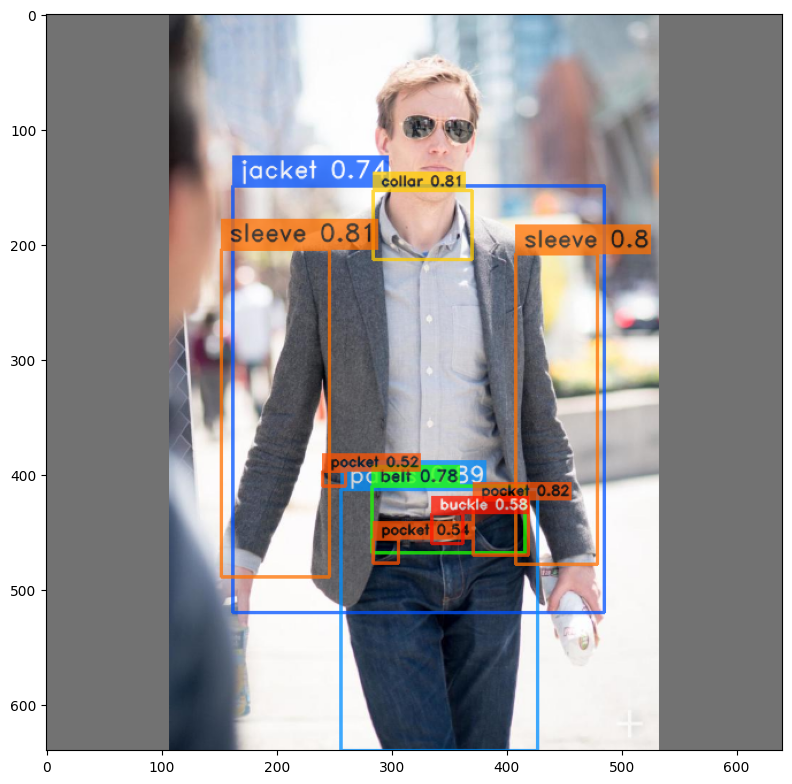

In [45]:
show_predictions_from_batch_format(image, predictions, conf=0.1)